In [1]:
# installing dependencies
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 5.0 MB/s 
     |████████████████████████████████| 163 kB 29.9 MB/s 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-pa

In [ ]:
# importing dependencies 
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

In [ ]:
# logging into huggingface hub
output.enable_custom_widget_manager()
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
# initializing entire pipeline for out of the box SD
device = 'cuda'

pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    thf_kHijIbvvUshVBPvKIeWbGKseGAiXzmWtnyorch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.12.self_attn.out_proj.weight', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.mlp.fc1.bias', 'vision_model.encoder.layers.13.layer_norm1.weight', 'vision_model.encoder.layers.20.layer_norm1.bias', 'vision_model.encoder.layers.2.mlp.fc2.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.weight', 'vision_model.encoder.layers.15.layer_norm2.weight', 'vision_model.encoder.layers.9.self_attn.q_proj.bias', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'vision_model.encoder.layers.22.mlp.fc1.weight', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.22.self_attn.k_proj.weight', 'vision_model.encoder.layers.13.layer_no

In [ ]:
# Stable Diffusion utils
class SDUtils():
  def __init__(
    self, device=device, pipe=pipe, vae=vae, tokenizer=tokenizer,
    text_encoder=text_encoder, unet=unet, scheduler=scheduler):
    
    self.device = device
    self.pipe = pipe
    self.vae = vae
    self.tokenizer = tokenizer
    self.text_encoder = text_encoder
    self.unet = unet
    self.scheduler = scheduler
    
  def encode_text(self, prompt):
    # Tokenize a prompt or a list of prompts and get embeddings
    text_input = self.tokenizer(
        prompt, padding='max_length', max_length=self.tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    with torch.no_grad():
      text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

    # Do the same for unconditional embeddings
    uncond_input = self.tokenizer(
        [''] * len(prompt), padding='max_length',
        max_length=self.tokenizer.model_max_length, return_tensors='pt')
    with torch.no_grad():
      uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

    # Cat for final embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings

  def denoise_img_latents(self, text_embeddings, height=512, width=512,
                      num_inference_steps=50, guidance_scale=7.5, latents=None, start_step=None):
    # apply text conditioned denoising steps, starting with noise
    if latents is None:
      latents = torch.randn((text_embeddings.shape[0] // 2, self.unet.in_channels, \
                            height // 8, width // 8))
    latents = latents.to(self.device)

    self.scheduler.set_timesteps(num_inference_steps)
    latents = latents * self.scheduler.sigmas[0]

    with autocast('cuda'):
      for i, t in tqdm(enumerate(self.scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = self.scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        with torch.no_grad():
          noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = self.scheduler.step(noise_pred, i, latents)['prev_sample']
    
    return latents
   
  def encode_img(self, imgs):
    # turn an image into image latents
    if not isinstance(imgs, list):
      imgs = [imgs]

    img_arr = np.stack([np.array(img) for img in imgs], axis=0)
    img_arr = img_arr / 255.0
    img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
    img_arr = 2 * (img_arr - 0.5)

    latent_dists = vae.encode(img_arr.to(device))
    latent_samples = latent_dists.sample()
    latent_samples *= 0.18215

    return latent_samples  

  def decode_img_latents(self, latents):
    # get images from image latents

    latents = 1 / 0.18215 * latents

    with torch.no_grad():
      imgs = self.vae.decode(latents)

    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in imgs]
    return pil_images

  def prompt_to_img(self, prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None):
    # go from a prompt or a list of prompts to generate image(s)

    if isinstance(prompts, str):
      prompts = [prompts]

    # Prompts -> text embeddings
    text_embeds = self.encode_text(prompts)

    # Text embeds -> img latents
    latents = self.denoise_img_latents(
        text_embeds, height=height, width=width, latents=latents,
        num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)
    
    # Img latents -> imgs
    imgs = self.decode_img_latents(latents)

    return imgs

  def imgs_to_video(self, imgs, video_name='video.mp4', fps=15):
    # turn list of images into an mp4
    video_dims = (imgs[0].width, imgs[0].height)
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')    
    video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
    for img in imgs:
      tmp_img = img.copy()
      video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
    video.release()

  def display_video(self, file_path, width=512):
    # play an mp4 file in colab
    compressed_vid_path = 'comp_' + file_path
    if os.path.exists(compressed_vid_path):
      os.remove(compressed_vid_path)
    os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

    mp4 = open(compressed_vid_path, 'rb').read()
    data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
    return HTML("""
      <video width={} controls>
            <source src="{}" type="video/mp4">
      </video>
      """.format(width, data_url))
    
  def perturb_latents(self, latents, scale=0.1):
    # jitter the image latents. Denoise and decode this to generate variations
    noise = torch.randn_like(latents)
    new_latents = (1 - scale) * latents + scale * noise
    return (new_latents - new_latents.mean()) / new_latents.std()
    
  def gen_i2i_latents(self, text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False, start_step=10):
    # create a noised version of the input image latents so we can denoise it to create an image conditioned on the input image
    # for usage in img_to_img()
    if latents is None:
      latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                            height // 8, width // 8))
    latents = latents.to(device)

    # New scheduler for img-to-img
    scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)
    
    scheduler.set_timesteps(num_inference_steps)
    if start_step > 0:
      start_timestep = scheduler.timesteps[start_step]
      start_timesteps = start_timestep.repeat(latents.shape[0]).long()

      noise = torch.randn_like(latents)
      latents = scheduler.add_noise(latents, noise, start_timesteps)

    latent_hist = [latents]
    with autocast('cuda'):
      for i, t in tqdm(enumerate(scheduler.timesteps[start_step:])):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        # predict the noise residual
        with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents)['prev_sample']
        latent_hist.append(latents)
    
    if not return_all_latents:
      return latents

    all_latents = torch.cat(latent_hist, dim=0)
    return all_latents

  def img_to_img(self, prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, img=None, return_all_latents=False,
                  batch_size=2, start_step=10):
    # image generation conditioned on an input image
    if isinstance(prompts, str):
      prompts = [prompts]

    # input image -> img latents
    input_img_latents = self.encode_img(img)

    # Prompts -> text embeds
    text_embeds = self.encode_text(prompts)

    # Text embeds -> img latents
    i2i_latents = self.gen_i2i_latents(
        text_embeds, height=height, width=width, latents=input_img_latents,
        num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
        return_all_latents=return_all_latents, start_step=start_step)
    
    # Img latents -> imgs
    all_imgs = []
    for i in tqdm(range(0, len(i2i_latents), batch_size)):
      imgs = self.decode_img_latents(i2i_latents[i:i+batch_size])
      all_imgs.extend(imgs)

    return all_imgs

  

In [ ]:
utils = SDUtils()

0it [00:00, ?it/s]

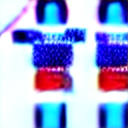

In [ ]:
# example of a normal text-conditioned image generation
img = utils.prompt_to_img(prompts='An astronaut riding a horse', height=128, width=128, num_inference_steps=50)[0]
display(img)

In [ ]:
# to see the latents
latents = utils.encode_img(img)
print(latents.shape)
# print(latents[:,:,::2,::2].shape)

torch.Size([1, 4, 16, 16])


In [ ]:
# # downsampling latents
# downsampled_latents = latents[:,:,::2,::2].cpu().detach().numpy()
# print(downsampled_latents.shape)

# from scipy import interpolate
# # upsampling latents
# x = np.array(range(downsampled_latents.shape[2]))
# y = np.array(range(downsampled_latents.shape[3]))

# f = interpolate.interp2d(x, y, downsampled_latents, kind='linear')

# xnew = np.linspace(0, 2, 64)
# ynew = np.linspace(0, 2, 64)
# upscaled_latents = f(xnew, ynew)

# print(upscaled_latents.shape)

(1, 4, 8, 8)


ValueError: ignored

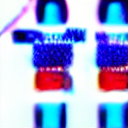

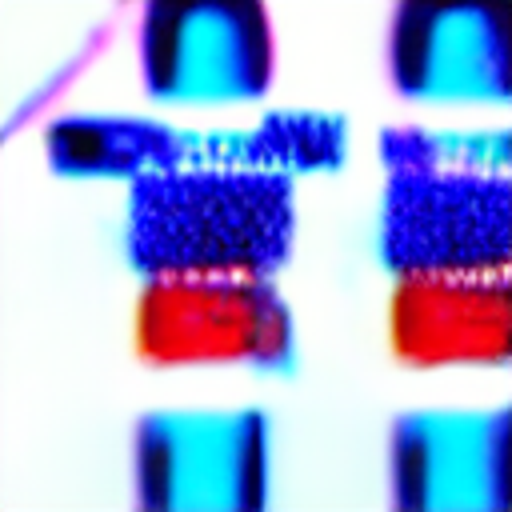

In [ ]:
# decoding the generated image to see how lossy the decoding was
reconstructed_img = utils.decode_img_latents(latents)[0]
upsampled_reconstructed_img = reconstructed_img.resize((512,512))
display(reconstructed_img)
display(upsampled_reconstructed_img)


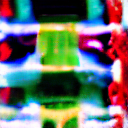

In [ ]:
# generating variation of the image
var_latents = utils.perturb_latents(latents, scale=0.15)
variation = utils.decode_img_latents(var_latents)
display(variation[0])

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

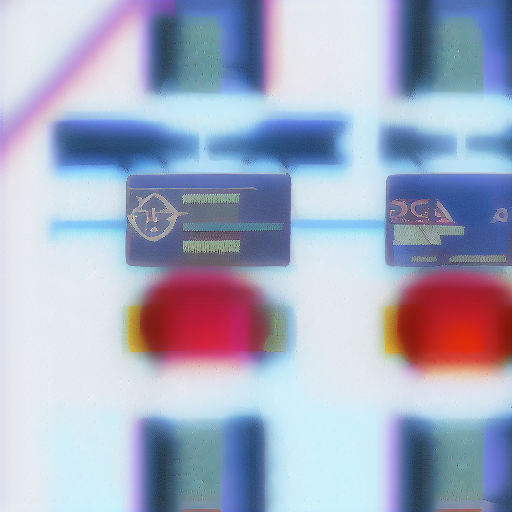

In [ ]:
# image-conditioned image generation. This is overloading my ram for some reason...
i2i_img = utils.img_to_img(prompts='Knights with knitted armor in skirts', num_inference_steps=200, img=upsampled_reconstructed_img, start_step=100)[0]
display(i2i_img)